In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import xgboost as xgb

In [ ]:
df = pd.read_csv("comprehensive_ebola_dataset.csv")

In [ ]:
df.head()

,name,age,gender,city,country,travel_history,fever,vomiting,diarrhea,bleeding,...,physician_notes,region,latitude,longitude,population_density,sanitation_rating,healthcare_access,climate,wildlife_exposure,Ebola_Diagnosis
0,Thomas Harris,40,Female,Laurenfort,Ghana,Kenya,True,False,False,False,...,Country everybody government.,North Dakota,83.146645,-54.614271,178,Fair,Extensive,Tropical,Yes,Yes
1,Stephanie Hill,70,Female,Ryanshire,Sierra Leone,Guinea-Bissau,False,False,False,False,...,Join similar respond cultural into.,Minnesota,-24.861071,-15.125626,838,Fair,Extensive,Temperate,Yes,No
2,Courtney Nelson,24,Female,Port Dianaburgh,Venezuela,Bosnia and Herzegovina,True,True,False,True,...,Value computer eat thousand.,Wyoming,-57.304210,-105.677243,572,Fair,Extensive,Hot,Yes,Yes
3,Shirley Hudson,66,Female,Dunnstad,New Zealand,Romania,True,True,True,True,...,Condition clearly especially public cause from.,Maryland,48.931755,-130.518832,782,Poor,Limited,Tropical,No,No
4,Jacob Martinez,29,Male,Angelshire,Uganda,Niger,False,True,True,True,...,Price word improve.,Hawaii,-77.367811,110.608387,355,Fair,Moderate,Temperate,No,Yes


In [ ]:
#Unwanted column
drop_cols = ["name", "physician_notes", "region", "pcr_result", "antibody_result"]
df.drop(columns=drop_cols, inplace=True)

In [ ]:
y = LabelEncoder().fit_transform(df["Ebola_Diagnosis"])
X = df.drop("Ebola_Diagnosis", axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool"]).columns.tolist()

In [ ]:
# Preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [ ]:
# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# Define common pipeline steps (preprocessing + feature selection)
pipeline_steps = [
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=30))
]

In [ ]:
#PCA
use_pca = False
if use_pca:
    final_steps = [('preprocessor', preprocessor),
                   ('pca', PCA(n_components=10, random_state=42))]
else:
    final_steps = [('preprocessor', preprocessor)]

Training

In [ ]:
models = {
    'RandomForest': (
        RandomForestClassifier(random_state=42),
        {
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [None, 10, 20]
        }
    ),
    'LogisticRegression': (
        LogisticRegression(max_iter=1000, random_state=42, penalty='l2'),
        {
            'clf__C': [0.1, 1, 10]
        }
    ),
    'XGBoost': (
        xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        {
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [3, 6],
            'clf__learning_rate': [0.01, 0.1],
            'clf__reg_alpha': [0, 0.5],         # L1 regularization
            'clf__reg_lambda': [1, 5]
        }
    ),
    'LightGBM': (
        LGBMClassifier(random_state=42),
        {
            'clf__n_estimators': [100, 200],
            'clf__num_leaves': [31, 50],
            'clf__lambda_l1': [0, 0.1],         # L1 regularization
            'clf__lambda_l2': [0, 1]
        }
    ),
    'CatBoost': (
        CatBoostClassifier(verbose=0, random_state=42),
        {
            'clf__iterations': [100, 200],
            'clf__depth': [3, 6],
            'clf__learning_rate': [0.01, 0.1],
            'clf__l2_leaf_reg': [1, 3, 5]
        }
    ),
    'SVM': (
        SVC(probability=True, random_state=42),
        {
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf']
        }
    )
}

In [ ]:
results = {}
accuracies = {}
for name, (model, param_grid) in models.items():
    print(f"\nTraining model: {name}")
    pipeline = Pipeline(steps=pipeline_steps + [('clf', model)])
    grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    #grid = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=5, n_iter=10, random_state=42, n_jobs=-1, scoring='accuracy')
    grid.fit(X_train, y_train)
    results[name] = grid
    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"\nModel: {name}")
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(f"Best cross-validation score for {name}: {grid.best_score_:.4f}")
    print(f"Best parameters for {name}: {grid.best_params_}")


Training model: RandomForest

Model: RandomForest
Accuracy: 0.8066666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.81      0.99      0.89       122

    accuracy                           0.81       150
   macro avg       0.41      0.50      0.45       150
weighted avg       0.66      0.81      0.73       150

Confusion Matrix:
 [[  0  28]
 [  1 121]]
Best cross-validation score for RandomForest: 0.7057
Best parameters for RandomForest: {'clf__max_depth': 10, 'clf__n_estimators': 100}

Training model: LogisticRegression

Model: LogisticRegression
Accuracy: 0.8133333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.81      1.00      0.90       122

    accuracy                           0.81       150
   macro avg       0.41      0.50      0.45       150
wei

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost/c


Model: XGBoost
Accuracy: 0.8133333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.81      1.00      0.90       122

    accuracy                           0.81       150
   macro avg       0.41      0.50      0.45       150
weighted avg       0.66      0.81      0.73       150

Confusion Matrix:
 [[  0  28]
 [  0 122]]
Best cross-validation score for XGBoost: 0.7400
Best parameters for XGBoost: {'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__reg_alpha': 0, 'clf__reg_lambda': 5}

Training model: LightGBM


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Number of positive: 259, number of negative: 91
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 350, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.740000 -> initscore=1.045969
[LightGBM] [Info] Start training from score 1.045969
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model: SVM
Accuracy: 0.8133333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.81      1.00      0.90       122

    accuracy                           0.81       150
   macro avg       0.41      0.50      0.45       150
weighted avg       0.66      0.81      0.73       150

Confusion Matrix:
 [[  0  28]
 [  0 122]]
Best cross-validation score for SVM: 0.7400
Best parameters for SVM: {'clf__C': 0.1, 'clf__kernel': 'linear'}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluation

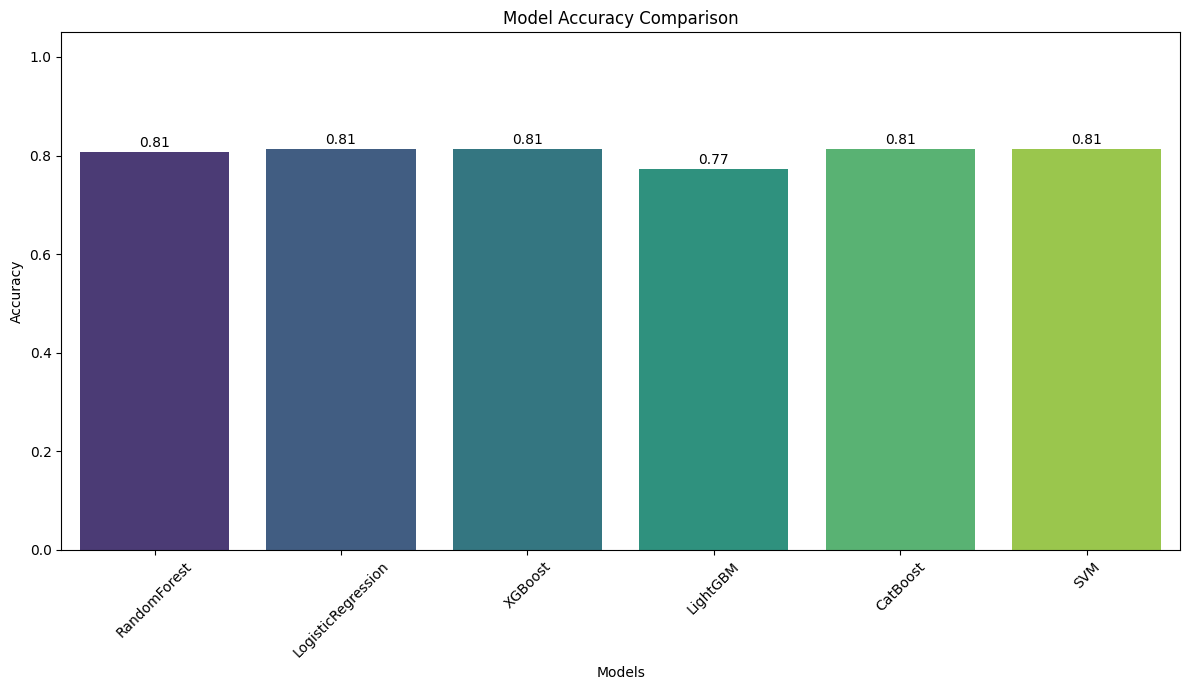

In [ ]:
#Plot Accuracy Comparison Across Models
plt.figure(figsize=(12, 7))
model_names = list(accuracies.keys())
accuracy_values = list(accuracies.values())
sns.barplot(x=model_names, y=accuracy_values, hue=model_names, palette='viridis', legend=False)
for i, v in enumerate(accuracy_values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

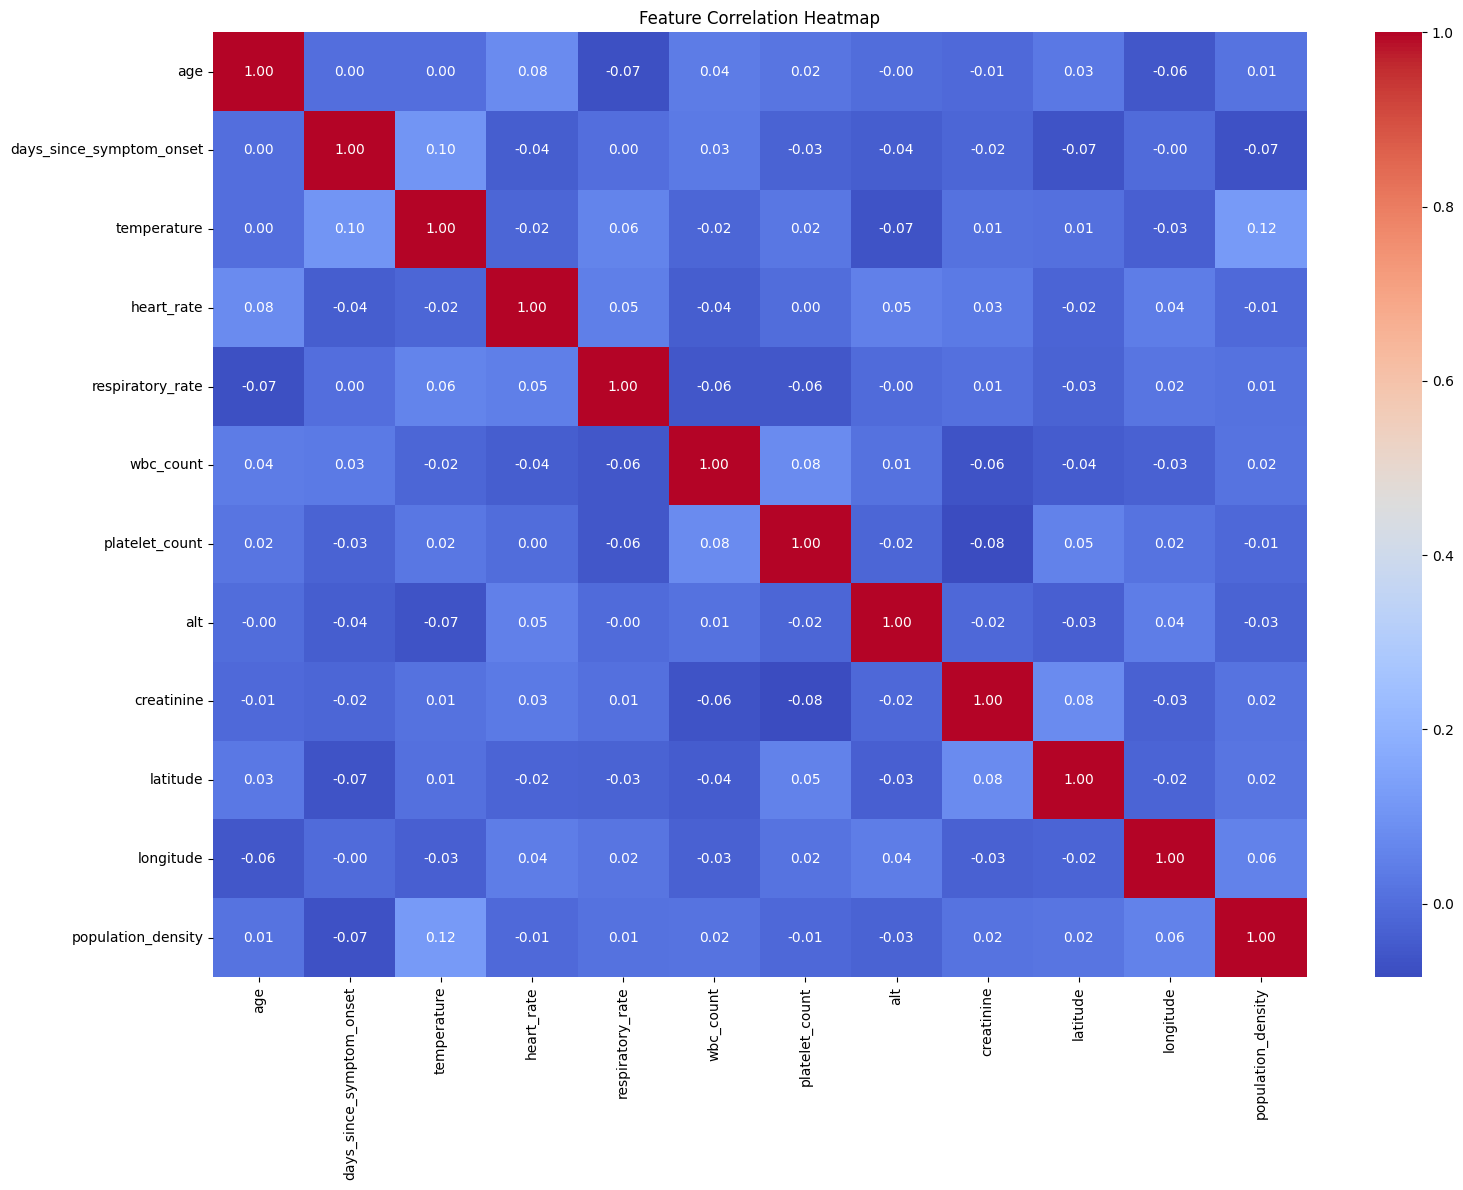

In [ ]:
# Heatmap of Feature Correlations
plt.figure(figsize=(16, 12))
corr_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

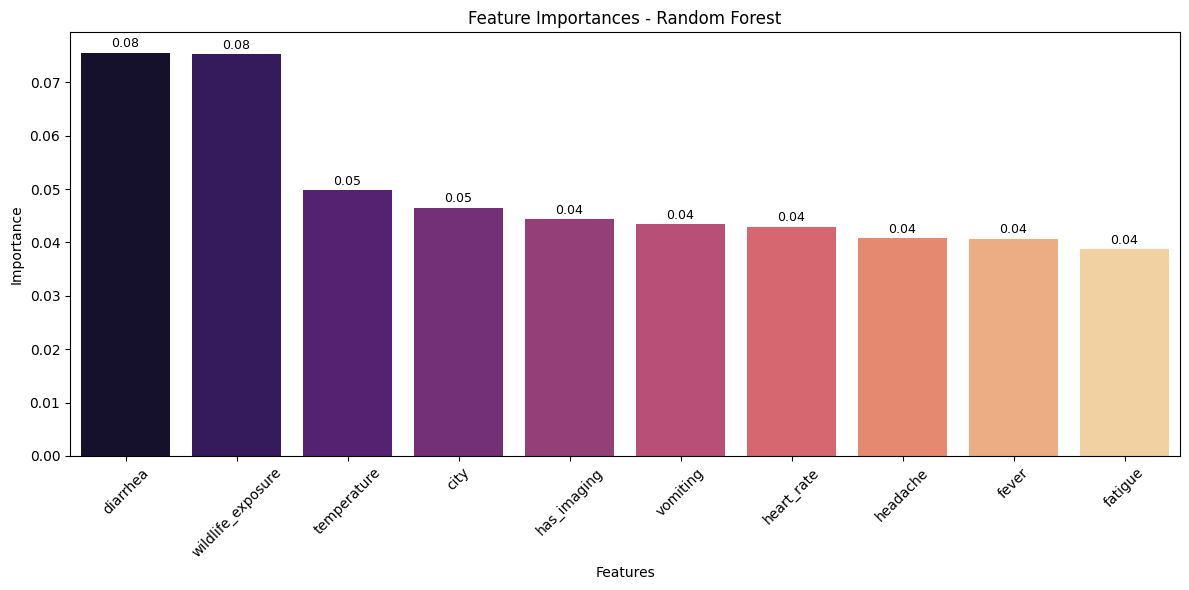

In [ ]:
# Plot Feature Importance for Random Forest
if 'RandomForest' in results:
    best_rf = results['RandomForest'].best_estimator_.named_steps['clf']
    feature_names = X.columns if not use_pca else [f'PC{i+1}' for i in range(best_rf.n_features_in_)]
    importances = best_rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances - Random Forest")
    sns.barplot(x=[feature_names[i] for i in indices[:10]], y=importances[indices[:10]], hue=[feature_names[i] for i in indices[:10]], palette='magma', legend=False)
    plt.ylabel("Importance")
    plt.xlabel("Features")
    plt.xticks(rotation=45)
    for i, v in enumerate(importances[indices[:10]]):
        plt.text(i, v + 0.001, f"{v:.2f}", ha='center', fontsize=9)
    plt.tight_layout()
    plt.show()